In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDet import *
from PossibleFunctionsDet import *
from BackgroundDet import *
from random import uniform
import random
import matplotlib
#%matplotlib auto

In [2]:
#THESE are functions wihout movement of the mirror
def fillcircle(r,center,num):
    ppr = int((4/np.pi)*np.sqrt(num)) #number of sections needed per quarter circle#points (sections) per radius
    xstart = (center[0] - r)
    xend = (center[0] + r)
    xs = np.linspace(xstart,xend,ppr)
    ystart = (center[1]-r)
    yend = (center[1]+r)
    ys = np.linspace(ystart,yend,ppr)
    points = []
    for i in range(len(xs)):
        for j in range (len(ys)):
            if (xs[i]-center[0])**2 + (ys[j]-center[1])**2 < r**2:
                p = [xs[i],ys[j]]
                points.append(p)
    return points

def checkoutrays(Rays,center,r):
    GRays = []
    BRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2)
        if d <= r**2: 
            GRays.append(Rays[i])
        else:
            BRays.append(Rays[i])
    return GRays,BRays

def gridlines(r,center,num):
    ppr = int((4/np.pi)*np.sqrt(num)) #number of sections needed per quarter circle#points (sections) per radius
    xstart = (center[0] - r)
    xend = (center[0] + r)
    xs = np.linspace(xstart,xend,ppr)
    ystart = (center[1]-r)
    yend = (center[1]+r)
    ys = np.linspace(ystart,yend,ppr)
    return xs,ys

def OFD(Rays): #output from detector
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTio,RRRRio,TTRRio,RTTRio,RTRTio,TRRTio,RRTTio,TRTRio]
        Ri = Rays[i]
        for j in range(8):
            out = Paths[j](Ri,p1,p2,p3,p4)
            if out is not None:
                Rayf.append(out)
    return Rayf
def sortgrid(Gtest): #assuming detector but can change
    for i in range(len(Gtest)):
        jx,jy = gridlines(7.9375,[160.375,-113],200)
        if len(Gtest[i])<7:
            Gtest[i].append(0.)
            Gtest[i].append(0.)
        for j in range(len(jx)):
            if Gtest[i][2][0] >= jx[j-1] and Gtest[i][2][0]<jx[j]:
                Gtest[i][5]=j
            if Gtest[i][2][0] <= jx[1]:
                Gtest[i][5]=1
            if Gtest[i][2][0]> jx[len(jx)-1]:
                Gtest[i][5]=len(jx)
        for k in range(len(jy)):
            if Gtest[i][2][1] >= jy[k-1] and Gtest[i][2][1]>=jy[k]:
                Gtest[i][6]=k
            if Gtest[i][2][1] <= jy[1]:
                Gtest[i][6]=1
            if Gtest[i][2][1]> jy[len(jy)-1]:
                Gtest[i][6]=len(jy)
    return Gtest

def regionalize(Gtestsorted):
    FullRegions = []
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    for j in range(len(jx)):
        for k in range(len(jy)):
            JK = [j,k]
            for i in range(len(Gtestsorted)):
                if Gtestsorted[i][5]==j and Gtestsorted[i][6]==k:
                    JK.append(i)
            if len(JK)>2:
                FullRegions.append(JK)
    return FullRegions

def RunAll(n): #just give number of rays to be run through this FTS
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(7.9375,sourcepointorigin,sourcethet,1000) #LOCAL
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    Rayf = OFD(Rays)
    G,B = checkoutrays(Rayf,[160.375,-113],7.9375)
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions

def gaussian3d(x,y,sig,mux,muy): #assuming is symmetric
    #sig = .3 #just guessing
    return (1/(np.sqrt(2*np.pi*(sig**2))*(sig**2)))*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

def jRegions(n):
    OutRays,regions=RunAll(n)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    DetTot = []
    for j in range(len(regions)):
        for i in range(len(Regions[j])): #All rays in region 1
            ExTot = []
            EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                #so there are 8 output rays YAY, what is expected
                #now use polarization angle and E_0 to get Z_x and Z_y 
                #CHECK IF I AM TRANSMITTING /REFLECTING E_0 CORRECTLY
                m,n = JRegion[0],JRegion[1]
                Raym = OutRays[JRegion[i]]
                if m != len(jx) and n !=len(jy):
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[m]+jx[m+1])/2,(jy[n]+jy[n+1])/2)
                else: 
                    w = 0
                Ex = w*np.abs(np.cos(Raym[0])*Raym[1])
                Ey = w*np.abs(np.sin(Raym[0])*Raym[1])
                ExTot.append(Ex)
                EyTot.append(Ey)
        Ij = (np.sum(ExTot))**2 + (np.sum(EyTot))**2
        DetTot.append(Ij)
    return DetTot

In [37]:
#the functions that incorporate movement of mirror
def OFDM(Rays,y): #output from detector wiht mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r):
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2)
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysM(n,y): #just give number of rays to be run through this FTS at a specific y!
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(7.9375,sourcepointorigin,sourcethet,1000) #LOCAL
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # # HERE 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions

def SumjRegionsM(n,y):
    OutRays,regions=RunRaysM(n,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    DetTot = []
    for j in range(len(regions)):
        for i in range(len(Regions[j])): #All rays in region 1
            ExTot = []
            EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                m,p = JRegion[0],JRegion[1]
                Raym = OutRays[JRegion[i]]
                if m == 17 or n == 17:
                    w = 0
                else:
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[m]+jx[m+1])/2,(jy[p]+jy[p+1])/2)
                Ex = w*np.abs(np.cos(Raym[0])*Raym[1])
                Ey = w*np.abs(np.sin(Raym[0])*Raym[1])
                ExTot.append(Ex)
                EyTot.append(Ey)
        Ij = (np.sum(ExTot))**2 + (np.sum(EyTot))**2
        DetTot.append(Ij)
    return np.sum(DetTot)


sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
sourcepoints = specsource(7.9375,sourcepointorigin,sourcethet,1000) #LOCAL
Rays = FSRay(100,sourcepoints, sourcethet,origin10)
Rayf = OFDM(Rays)

In [43]:
def RunFTS(n,div):
    Power = []
    Delay = []
    for y in np.linspace(-25,25,div):
        I = SumjRegionsM(n,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay
        

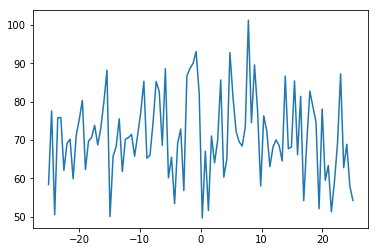

In [44]:
P,D = RunFTS(1000,100)
pl.plot(D,P)
pl.show()

now add the PHASE. dumbass. there is literally no interference without phase.... ok so assign each ray a WAVELENGTH.